# Convolutional neural network

## Librairies

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Constantes du dataset et de l'entraînement

In [2]:
PATH = "Dataset/"
IMAGE_TYPE = ["Brain Tumor CT scan Images", "Brain Tumor MRI images"]
PATIENT_TYPE = ["Healthy", "Tumor"]

WEIGHTS_PATH1 = "Model/ct_best.weights.h5"
WEIGHTS_PATH2 = "Model/mri_best.weights.h5"
WEIGHTS_PATH3 = "Model/commun_best.weights.h5"

SIZE = (128, 128)
BATCH = 64
EPOCHS = 10
BUFFER = 1024

#### Gestion des fichiers créés pendant l'entrainement

In [3]:
def remove_file(path):
    try:
        os.remove(path)
    except OSError:
        pass

os.makedirs("Model/", exist_ok=True)
remove_file(WEIGHTS_PATH1)
remove_file(WEIGHTS_PATH2)
remove_file(WEIGHTS_PATH3)

## Récupération des dataset

- Toutes les images contenues dans le dataset ne sont pas de la **même tailles**, et ne sont pas toutes carrées. A cause de ca on a été obligé de faire un pré-traitement des images pour garantir le bon entraînement du modèle.

  - On a choisi de redimensionner les images en tailles **(128 * 128) pixels**, c'est un juste milieu entre une bonne précision et un temps d'entrainement trop long car le nombre de paramètre de notre modèle augmente drastiquement en fonction de la taille de l'entrée.
  - Dans un premier temps nous avions essayé de redimensionner en tailles (192 * 192) mais le temps de calcule était presque doublé tandis que la précision n'a pas changé.

- On garde les images comme si elles étaient en couleur (rgb) car la précision du modèle diminue si nous décidons de les transformer en *grayscale* (même si a première vue elles sont en noir et blanc).
- On utilise **70%** des données pour l'entrainement et **30%** pour la validation.

In [4]:
# Dataset des CT scans
ct_train_ds, ct_val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=PATH + IMAGE_TYPE[0],
    label_mode='categorical',
    color_mode='rgb',
    batch_size=None,
    image_size=SIZE,
    shuffle=True,
    seed=7,
    validation_split=0.3,
    subset='both',
    verbose=True
)

# Dataset des IRM
mri_train_ds, mri_val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=PATH + IMAGE_TYPE[1],
    label_mode='categorical',
    color_mode='rgb',
    batch_size=None,
    image_size=SIZE,
    shuffle=True,
    seed=7,
    validation_split=0.3,
    subset='both',
    verbose=True
)

Found 4618 files belonging to 2 classes.
Using 3233 files for training.
Using 1385 files for validation.
Found 5000 files belonging to 2 classes.
Using 3500 files for training.
Using 1500 files for validation.


## Préparation du dataset

- **Concatenations** des 2 datasets pour créer un grand dataset commun (Scan + IRM).
- **Shuffle** après la concatenation pour que les images de scanner et d'IRM se mélange dans les batchs.
- Mise en **batch** des datasets pour l'entraînement.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = ct_train_ds.concatenate(mri_train_ds).shuffle(buffer_size=BUFFER, seed=11).batch(BATCH).prefetch(AUTOTUNE)
val_ds = ct_val_ds.concatenate(mri_val_ds).shuffle(buffer_size=BUFFER, seed=11).batch(BATCH).prefetch(AUTOTUNE)

ct_train_ds, ct_val_ds = ct_train_ds.batch(BATCH).prefetch(AUTOTUNE), ct_val_ds.batch(BATCH).prefetch(AUTOTUNE)
mri_train_ds, mri_val_ds = mri_train_ds.batch(BATCH).prefetch(AUTOTUNE), mri_val_ds.batch(BATCH).prefetch(AUTOTUNE)

## Visualisation d'images du dataset

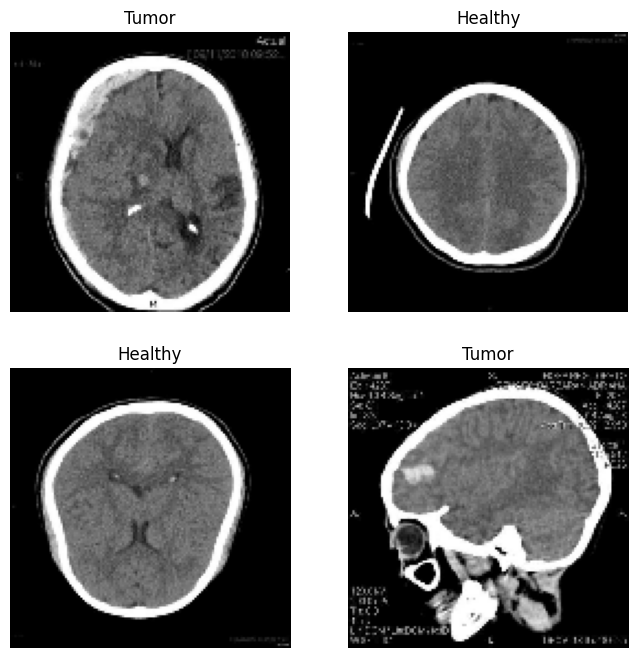

In [31]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        label_index = tf.argmax(labels[i]).numpy()
        plt.title(PATIENT_TYPE[label_index])
        plt.axis('off')

## Visualisation de la qualité de l'entraînement

- Créé un graphe pour visualiser la valeur de loss du modèle sur les dataset d'entraînement et de validation pour chaque epochs.
- Créé un second graphe pour visualiser la valeur de précision du modèle sur les dataset d'entraînement et de validation pour chaque epochs.

In [7]:
def plot_curves(history, model):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(1, len(history.history['loss']) + 1)

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.savefig(f"Images/{model}_loss.png", dpi=300, bbox_inches='tight')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.savefig(f"Images/{model}_accuracy.png", dpi=300, bbox_inches='tight')
  plt.legend()

## Définition du CNN

On a choisi de faire un CNN avec 4 couches **convolutive** chacune suivie d'une couche de **pooling**.
- On commence par faire un **Rescaling**, ca permet d'avoir des valeurs d'entrée sur [0, 1] et d'améliorer la stabilité et la vitesse d'apprentissage.
- Pour la première convolution on applique un **filtre (5, 5)** pour favoriser la détection de grand motifs.
- Ensuite on utilise des **filtres (3, 3)** car l'image étant seulement de taille (128, 128) celà suffit à ce que les motifs se propage au fur des convolutions.
- Les couches denses du MLP sont de tailles **(1024, 128, 2)**:
  - 1024 permet de pouvoir bien capter les différents motifs de l'image;
  - 128 pour affiner le résultat;
  - une sortie avec 2 perceptron en activation softmax permet d'avoir une **probabilité** de Tumeur ou non avec la somme égale à 1 (parfait pour la reconnaissance d'image que nous voulons).

In [8]:
def cnnModel():
    model = Sequential()
    model.add(keras.layers.Input(shape=(128, 128, 3)))
    model.add(keras.layers.Rescaling(1./255))
    # Layer 1
    model.add(keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    # Layer 2
    model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    # Layer 3
    model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    # Layer 4
    model.add(keras.layers.Conv2D(192, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    # Flatten
    model.add(keras.layers.Flatten())

    # MLP
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(2, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    return model

## Entraînement des modèles

Utilisation du "callback ModelCheckpoint" qui permet d'enregistrer les paramètres de la meilleure époque (minimum de validation loss) afin de garder le meilleur modèle (particulièrement utile en cas d'overfitting).

#### 1. Pour entraîné le modèle des **Scanner**

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - accuracy: 0.7128 - loss: 0.6979 - val_accuracy: 0.8989 - val_loss: 0.2525
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - accuracy: 0.9102 - loss: 0.2145 - val_accuracy: 0.9430 - val_loss: 0.1527
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - accuracy: 0.9513 - loss: 0.1266 - val_accuracy: 0.9538 - val_loss: 0.1250
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 426ms/step - accuracy: 0.9657 - loss: 0.0873 - val_accuracy: 0.9372 - val_loss: 0.1347
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 438ms/step - accuracy: 0.9656 - loss: 0.0828 - val_accuracy: 0.9617 - val_loss: 0.0946
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 427ms/step - accuracy: 0.9797 - loss: 0.0468 - val_accuracy: 0.9625 - val_loss: 0.0970
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 427ms/step - accuracy: 0.9785 - loss: 0.0443 - val_accuracy: 0.9603 - val_loss: 0.1313
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 441ms/step - accuracy: 0.9879 - loss: 0.0311 - val_accu

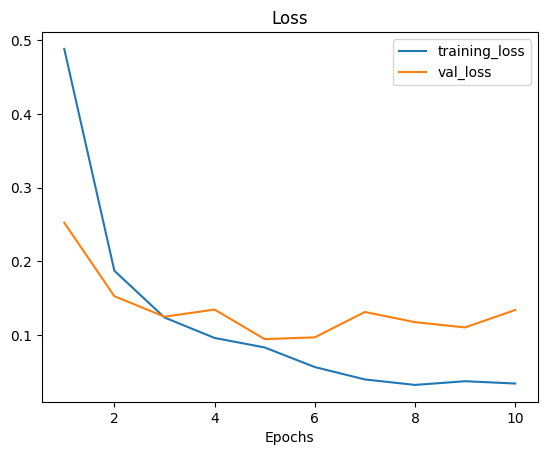

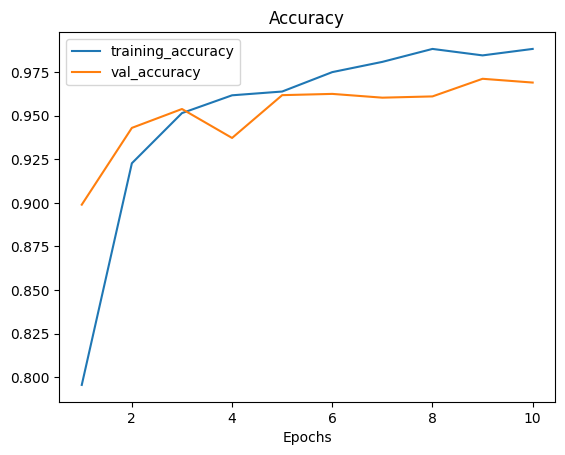

In [9]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=WEIGHTS_PATH1,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

model_ct = cnnModel()
history_ct = model_ct.fit(ct_train_ds, validation_data=ct_val_ds, epochs=EPOCHS, callbacks=[checkpoint_callback])
model_ct.load_weights(WEIGHTS_PATH1)
plot_curves(history_ct, "ct")

#### 2. Pour entraîné le modèle des **IRM**

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 25s 436ms/step - accuracy: 0.6104 - loss: 0.6469 - val_accuracy: 0.8120 - val_loss: 0.3940
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 414ms/step - accuracy: 0.8323 - loss: 0.3845 - val_accuracy: 0.8807 - val_loss: 0.2891
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 429ms/step - accuracy: 0.9193 - loss: 0.2195 - val_accuracy: 0.9387 - val_loss: 0.1741
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 401ms/step - accuracy: 0.9549 - loss: 0.1285 - val_accuracy: 0.9580 - val_loss: 0.1223
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 420ms/step - accuracy: 0.9665 - loss: 0.0891 - val_accuracy: 0.9593 - val_loss: 0.1039
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 423ms/step - accuracy: 0.9796 - loss: 0.0545 - val_accuracy: 0.9733 - val_loss: 0.0813
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 431ms/step - accuracy: 0.9899 - loss: 0.0262 - val_accuracy: 0.9507 - val_loss: 0.1718
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 429ms/step - accuracy: 0.9837 - loss: 0.0567 - val_accu

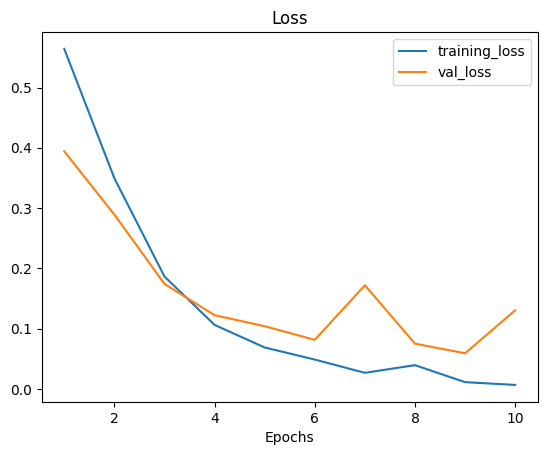

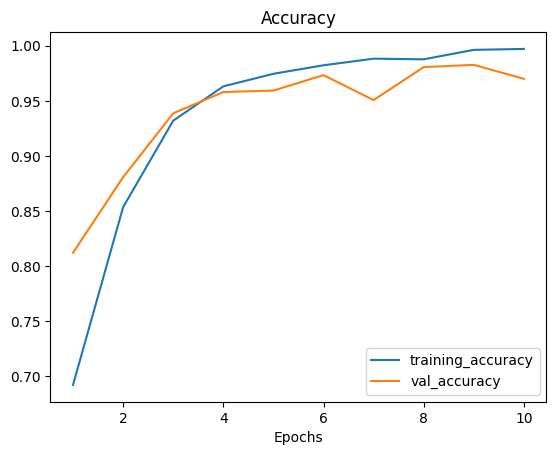

In [10]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=WEIGHTS_PATH2,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

model_mri = cnnModel()
history_mri = model_mri.fit(mri_train_ds, validation_data=mri_val_ds, epochs=EPOCHS, callbacks=[checkpoint_callback])
model_mri.load_weights(WEIGHTS_PATH2)
plot_curves(history_mri, "mri")

#### 3. Pour entraîné le modèle des **Scanner et des IRM**

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 47s 431ms/step - accuracy: 0.7216 - loss: 0.5088 - val_accuracy: 0.7698 - val_loss: 0.5172
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 44s 410ms/step - accuracy: 0.8962 - loss: 0.2377 - val_accuracy: 0.9016 - val_loss: 0.2399
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 44s 409ms/step - accuracy: 0.9274 - loss: 0.1706 - val_accuracy: 0.9324 - val_loss: 0.2000
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 44s 410ms/step - accuracy: 0.9533 - loss: 0.1297 - val_accuracy: 0.9435 - val_loss: 0.1827
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 44s 410ms/step - accuracy: 0.9668 - loss: 0.0934 - val_accuracy: 0.9563 - val_loss: 0.1573
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 44s 411ms/step - accuracy: 0.9674 - loss: 0.0930 - val_accuracy: 0.9594 - val_loss: 0.1338
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 45s 424ms/step - accuracy: 0.9731 - loss: 0.0728 - val_accuracy: 0.9695 - val_loss: 0.1218
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 45s 425ms/step - accuracy: 0.9839 - loss: 0

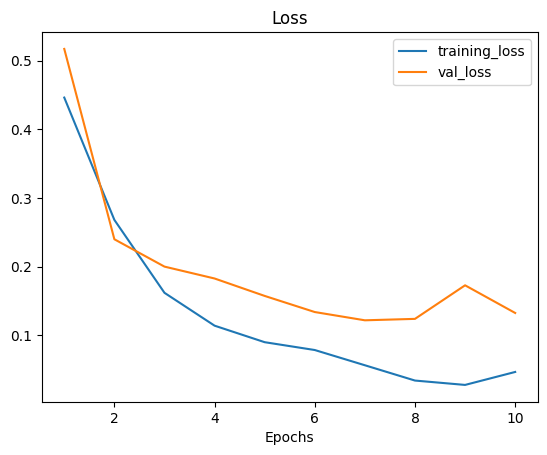

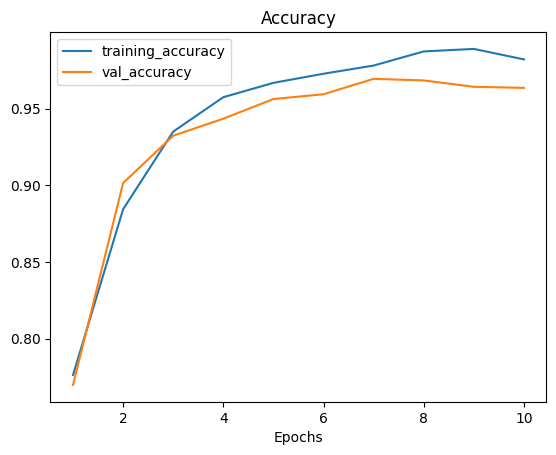

In [11]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=WEIGHTS_PATH3,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

model_commun = cnnModel()
history_commun = model_commun.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[checkpoint_callback])
model_commun.load_weights(WEIGHTS_PATH3)
plot_curves(history_commun, "commun")

## Evaluation

Permet de voir les performances de nos modèles par rapport à la loss et à la précision, sur le dataset de validation.

#### 1. Pour le modèle entraîné sur les **Scanner**

In [12]:
test_loss, test_accuracy = model_ct.evaluate(ct_val_ds)
print(f"Loss: {test_loss:.4f}   |   Accuracy: {test_accuracy*100:.1f}%")

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9659 - loss: 0.0904
Loss: 0.0946   |   Accuracy: 96.2%


#### 2. Pour le modèle entraîné sur les **IRM**

In [13]:
test_loss, test_accuracy = model_mri.evaluate(mri_val_ds)
print(f"Loss: {test_loss:.4f}   |   Accuracy: {test_accuracy*100:.1f}%")

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.9856 - loss: 0.0565
Loss: 0.0591   |   Accuracy: 98.3%


#### 3. Pour le modèle entraîné sur les **Scanner et IRM**

In [14]:
test_loss, test_accuracy = model_commun.evaluate(val_ds)
print(f"Loss: {test_loss:.4f}   |   Accuracy: {test_accuracy*100:.1f}%")

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9671 - loss: 0.1170
Loss: 0.1218   |   Accuracy: 96.9%


## Sauvegarde et Chargement des modèles

#### 1. Pour le modèle entraîné sur les **Scanner**

In [15]:
# Sauvegarde du modèle scanner
model_ct.save('Model/cnn_ct.keras')

In [16]:
# Chargement du modèle scanner
model_ct = keras.models.load_model('Model/cnn_ct.keras')
# model_ct.summary()

#### 2. Pour le modèle entraîné sur les **IRM**

In [17]:
# Sauvegarde du modèle IRM
model_mri.save('Model/cnn_irm.keras')

In [18]:
# Chargement du modèle IRM
model_irm = keras.models.load_model('Model/cnn_irm.keras')

#### 3. Pour le modèle entraîné sur les **Scanner et IRM**

In [19]:
# Sauvegarde du modèle commun
model_commun.save('Model/cnn_commun.keras')

In [20]:
# Chargement du modèle commun
model_commun = keras.models.load_model('Model/cnn_commun.keras')

### Visualisation de la prédiction des modèles

In [21]:
def plot_prediction(model, model_name, val_ds):
    plt.figure(figsize=(10, 10))
    plt.suptitle(f"Prédictions pour le modèle : {model_name}", fontsize=16)
    plt.subplots_adjust(top=0.9)

    for images, labels in val_ds.take(1):
        predictions = model.predict(images)

        for i in range(8):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            
            label_index = tf.argmax(labels[i]).numpy()
            true_label = PATIENT_TYPE[label_index]

            pred_index = tf.argmax(predictions[i]).numpy()
            predicted_label = PATIENT_TYPE[pred_index]
            plt.title(f"Réel: {true_label}\nPrédit: {predicted_label} {max(predictions[i])*100:.0f}%")
            plt.axis('off')

    plt.savefig(f"Images/{model_name}_prediction.png", dpi=300, bbox_inches='tight')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


2025-01-10 20:09:12.444984: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


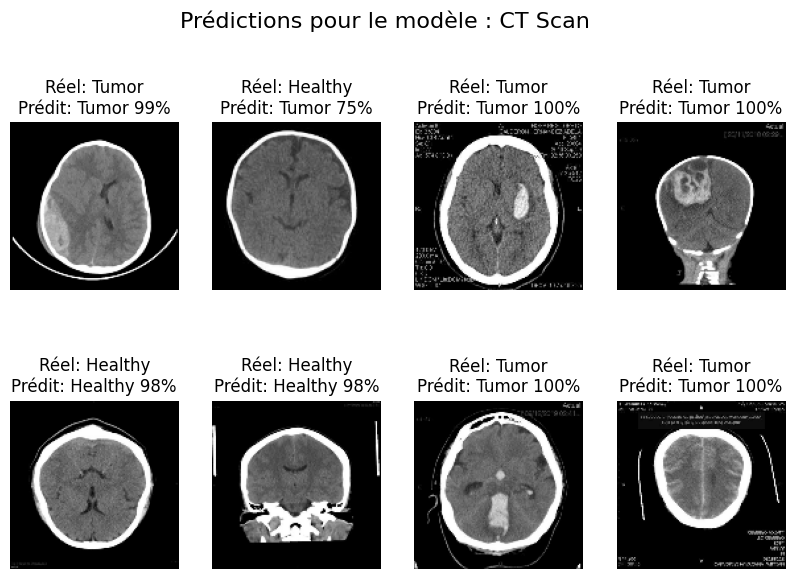

In [22]:
plot_prediction(model_ct, "CT Scan", ct_val_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


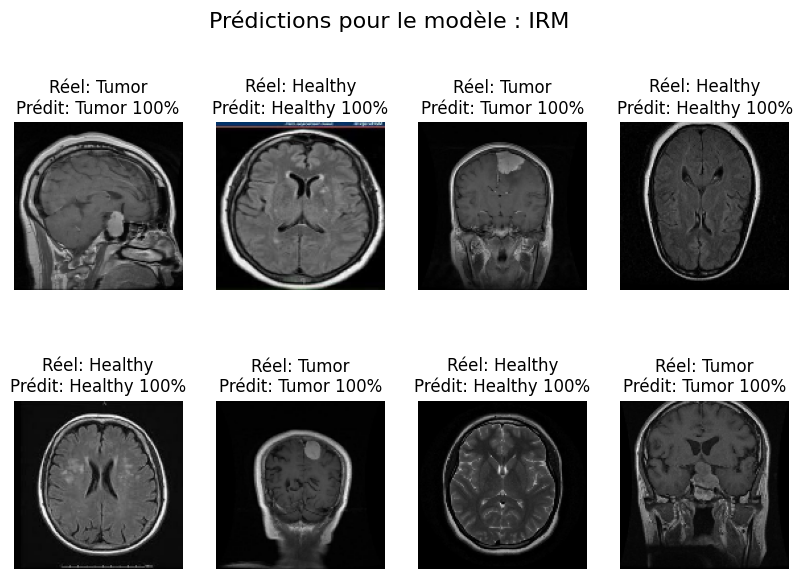

In [23]:
plot_prediction(model_irm, "IRM", mri_val_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


2025-01-10 20:09:14.205284: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


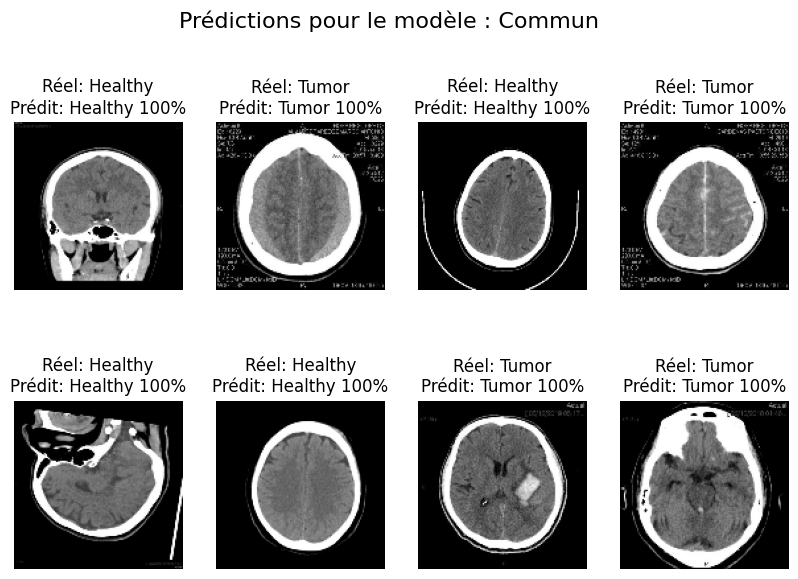

In [24]:
plot_prediction(model_commun, "Commun", val_ds)